## 1. Import Library
___

In [1]:
import os
import gc
import ctypes
import sys
import random
from tqdm import tqdm

import shutil
import numpy as np
import pandas as pd
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore

import cv2
from PIL import Image

import torch
import torch.nn as nn

from sklearn.model_selection import GroupKFold

import warnings
warnings.filterwarnings('ignore')

#### Configuration

In [2]:
class CFG:
    output_dir = 'runs/detect'
    seed = 42

    img_size = [256,256]
    num_classes = 3 # Ulcer, Polyp, Cancer
    
    epoch = 300
    warmup_epoch = 0
    patience = 10
    batch = 16
    optimizer = 'AdamW'
    amp = True
    base_lr = 1e-3
    base_lr_min = 1e-6
    weight_decay = 1e-3

    conf = 0.0
    iou = 0.7
    max_det = 500

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### Reproducibility

In [3]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    os.environ['PYTHONHASHSEED'] = str(seed)

seed_everything(CFG.seed)

#### Clean_memory

In [4]:
def clean_memory():
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()

clean_memory()

## 2. Road and Read Data
___

In [5]:
df = pd.read_csv('/kaggle/input/metadataset/colonoscopy_data2.csv')
print('Shape of DataFrame: ', df.shape)
print(display(df))

Shape of DataFrame:  (2496, 14)


,image_id,height,width,organ,lesion_label,location,shape_type_polygon,polygon_mask,bounding_box_shape,x_min,y_min,x_max,y_max,lesion
0,2_1_00001.png,2048,2048,colonoscopy,0,1,polygon,"1484.52,775.16;1516.82,710.56;1519.30,640.99;1...",rectangle,838.559006,149.068323,1519.304348,807.453416,ulcer
1,2_1_00001.png,2048,2048,colonoscopy,0,1,polygon,"1663.40,1478.26;1653.47,1426.09;1616.20,1388.8...",rectangle,1310.608696,1324.223602,1663.403727,1868.322981,ulcer
2,2_1_00002.png,2048,2048,colonoscopy,0,1,polygon,"687.01,223.60;687.01,273.29;704.40,337.89;726....",rectangle,687.006211,168.944099,1591.354037,1465.838509,ulcer
3,2_1_00002.png,2048,2048,colonoscopy,0,1,polygon,"826.14,1200.00;878.31,1207.45;932.97,1187.58;9...",rectangle,488.248447,434.782609,1007.503106,1207.453416,ulcer
4,2_1_00002.png,2048,2048,colonoscopy,0,1,polygon,"575.20,1038.51;520.55,1050.93;468.37,1050.93;4...",rectangle,212.472050,725.465839,607.503106,1050.931677,ulcer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2491,2_2_05111.png,2048,2048,colonoscopy,1,1,polygon,"1113.11,963.83;1070.55,976.60;1032.26,995.74;1...",rectangle,898.212766,948.936170,1493.957447,1527.659574,polyp
2492,2_2_05112.png,2048,2048,colonoscopy,1,1,polygon,"1230.13,1397.87;1187.57,1408.51;1138.64,1425.5...",rectangle,866.297872,1370.212766,1821.617021,1889.361702,polyp
2493,2_2_05113.png,2048,2048,colonoscopy,1,1,polygon,"1021.62,642.55;979.06,653.19;938.64,668.09;898...",rectangle,810.978723,642.553192,1268.425532,1038.297872,polyp
2494,2_2_05114.png,2048,2048,colonoscopy,1,1,polygon,"883.32,972.34;845.02,997.87;806.72,1025.53;776...",rectangle,772.680851,970.212766,1121.617021,1223.404255,polyp


None


#### Image Path

In [6]:
train_id = [x.split('/')[-1] for x in glob('/kaggle/input/colonoscopy-256x256-resized-png/train/*.png')]
train_df = df[df['image_id'].isin(train_id)].reset_index(drop=True)
print('=> Number of Unique Image_id in Train: ', train_df.image_id.nunique())

image_path = {os.path.basename(x): x for x in glob('/kaggle/input/colonoscopy-256x256-resized-png/train/*.png')}

train_df['path'] =  train_df['image_id'].map(image_path)

=> Number of Unique Image_id in Train:  1596


#### Rescaling 0~1(Xmid, Ymid, Width, Height)

In [7]:
train_df['x_min'] = train_df['x_min'] / train_df['width']
train_df['y_min'] = train_df['y_min'] / train_df['height']

train_df['x_max'] = train_df['x_max'] / train_df['width']
train_df['y_max'] = train_df['y_max'] / train_df['height']

train_df['x_mid'] = (train_df['x_max'] + train_df['x_min']) / 2
train_df['y_mid'] = (train_df['y_max'] + train_df['y_min']) / 2

train_df['w'] = train_df['x_max'] - train_df['x_min'] 
train_df['h'] = train_df['y_max'] - train_df['y_min']

#### Split Train & Val

In [8]:
gkf = GroupKFold(n_splits=5)

for i, (_, val_idx) in enumerate(gkf.split(train_df, groups=train_df['image_id'])):
    train_df.loc[val_idx, 'fold'] = i

valid_df = train_df[train_df['fold'] == 0].reset_index(drop=True)
train_df = train_df[train_df['fold'] != 0].reset_index(drop=True)

print('Images in train_df: ', train_df['image_id'].nunique())
print('Images in valid_df: ', valid_df['image_id'].nunique())

Images in train_df:  1277
Images in valid_df:  319


## 3. Write Yacs File
___

In [9]:
#### lesion_label
## ulcer: 0
## polyp: 1
## cancer: 2

In [10]:
## Image
os.makedirs(f'{CFG.output_dir}/train/images', exist_ok=True)
os.makedirs(f'{CFG.output_dir}/val/images', exist_ok=True)

## Label
os.makedirs(f'{CFG.output_dir}/train/labels', exist_ok=True)
os.makedirs(f'{CFG.output_dir}/val/labels', exist_ok=True)

## Train 
train_files = train_df['path'].unique()
for file in tqdm(train_files, total=len(train_files), desc='Building Train Scripts'):
    shutil.copy(file, f'{CFG.output_dir}/train/images')

    image_id = file.split('/')[-1]
    label = train_df[train_df['image_id'] == image_id][['lesion_label','x_mid','y_mid','w','h']]

    label_path = os.path.join(f'{CFG.output_dir}/train/labels',f'{image_id.split(".")[0]}.txt')
    with open(label_path,'w') as f:
        for _, row in label.iterrows():
            f.write(f"{int(row['lesion_label'])} {row['x_mid']} {row['y_mid']} {row['w']} {row['h']}\n")
## Val
val_files = valid_df['path'].unique()
for file in tqdm(val_files, total=len(val_files), desc='Building Val Scripts'):
    shutil.copy(file, f'{CFG.output_dir}/val/images')

    image_id = file.split('/')[-1]
    label = valid_df[valid_df['image_id'] == image_id][['lesion_label','x_mid','y_mid','w','h']]

    label_path = os.path.join(f'{CFG.output_dir}/val/labels',f'{image_id.split(".")[0]}.txt')
    with open(label_path, 'w') as f:
        for _, row in label.iterrows():
            f.write(f"{int(row['lesion_label'])} {row['x_mid']} {row['y_mid']} {row['w']} {row['h']}\n")
            

Building Val Scripts: 100%|██████████| 319/319 [00:03<00:00, 86.70it/s]


In [11]:
import yaml

data = dict(
    train = f'{CFG.output_dir}/train/',
    val = f'{CFG.output_dir}/val/',
    nc = CFG.num_classes,
    names = ['ulcer','polyp','cancer'],)

with open('/kaggle/working/colonoscopy.yaml', 'w') as f:
    yaml.dump(data, f, default_flow_style=False)

In [12]:
with open('/kaggle/working/colonoscopy.yaml', 'r') as f:
    print(f.read())

names:
- ulcer
- polyp
- cancer
nc: 3
train: runs/detect/train/
val: runs/detect/val/



## 4. Train Yolo Vit Model
___

In [13]:
print(f'{Fore.LIGHTGREEN_EX}Installing ultralytics')
!pip install -q ultralytics
import ultralytics
ultralytics.checks()

Ultralytics 8.3.84 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6170.0/8062.4 GB disk)


In [14]:
from ultralytics import RTDETR

In [15]:
model = RTDETR('rtdetr-l.pt')

100%|██████████| 63.4M/63.4M [00:00<00:00, 120MB/s]


In [16]:
model.train(
            ### Training Settings
            data='/kaggle/working/colonoscopy.yaml', # path to data file, i.e. coco8.yaml
            epochs=CFG.epoch, # (int) number of epochs to train for
            patience=CFG.patience, # (int) epochs to wait for no observable improvement
            imgsz=CFG.img_size[0], # (int | list) input images size(default: 640) # list[h,w]  
            batch=CFG.batch, # (int) number of images per batch (-1 for AutoBatch) # default: 16
            device=0, # device=0,1,2,3, device=cpu
            save=True, # save train checkpoints and predict results
            cache='disk', # Use cache for data loading
            verbose=True,
            exist_ok = True, # whether to overwrite existing experiment
            project = f'/kaggle/working/{CFG.output_dir}',
            seed = CFG.seed, 
            optimizer= CFG.optimizer, # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
            close_mosaic=5, # disable mosaic augmentations for final epochs
            cos_lr = True,
            amp= CFG.amp, # Automatic Mixed Precision(AMP) training
    
            ### HyperParameters
            lr0 = CFG.base_lr, # initial learning rate(i.e. SGD: 1e-2, Adam: 1e-3)
            lrf = CFG.base_lr_min, # final learning rate(1r0*1rf)
            weight_decay = CFG.weight_decay,
            warmup_epochs = CFG.warmup_epoch, # default:3
            hsv_h = 0, # (float) Hue Augmentation(fraction) # 색상 변화(빨강 -> 오렌지 -> 노랑색)
            hsv_s = 0.2, # (float) Saturation Augmentation(fraction) # 선명하거나, 흐릿하거나
            hsv_v = 0, # (float) Value Augmentation(fraction) # 밝아지거나, 어두워지거나
            degrees=2.5, # (float) image rotation (+/- deg)
            translate=0.01, # (float) image transflation (+/- fraction)
            scale = 0.1, # (float) image scale(+/- gain)
            shear = 0, # (float) image shear (+/- deg)
            flipud= 0.0, fliplr= 0.5, # vertical & horizontal flip  
            mosaic = 0.05, # (float) image mosaic(probability)
            mixup = 0.05, # (float) image mixup(probability)
            erasing = 0,

            ### Val/Test Settings
            val = False, # validate/test during training, # Epoch마다 평가함(False이면 맨마지막에만 평가함)
            split = 'val', # dataset split to use for validation
            conf = CFG.conf, # default: val(0.001), predict(0.25)
            iou = CFG.iou, # Iou threshold for NMS
            max_det = CFG.max_det, # default: 300
            plots = True, # save plots and images during train/val
           )

Ultralytics 8.3.84 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=rtdetr-l.pt, data=/kaggle/working/colonoscopy.yaml, epochs=300, time=None, patience=10, batch=16, imgsz=256, save=True, save_period=-1, cache=disk, device=0, workers=8, project=/kaggle/working/runs/detect, name=train, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=5, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=False, split=val, save_json=False, save_hybrid=False, conf=0.0, iou=0.7, max_det=500, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_la

100%|██████████| 755k/755k [00:00<00:00, 21.5MB/s]


Overriding model.yaml nc=80 with nc=3
WARNING ⚠️ no model scale passed. Assuming scale='l'.

                   from  n    params  module                                       arguments                     
  0                  -1  1     25248  ultralytics.nn.modules.block.HGStem          [3, 32, 48]                   
  1                  -1  6    155072  ultralytics.nn.modules.block.HGBlock         [48, 48, 128, 3, 6]           
  2                  -1  1      1408  ultralytics.nn.modules.conv.DWConv           [128, 128, 3, 2, 1, False]    
  3                  -1  6    839296  ultralytics.nn.modules.block.HGBlock         [128, 96, 512, 3, 6]          
  4                  -1  1      5632  ultralytics.nn.modules.conv.DWConv           [512, 512, 3, 2, 1, False]    
  5                  -1  6   1695360  ultralytics.nn.modules.block.HGBlock         [512, 192, 1024, 5, 6, True, False]
  6                  -1  6   2055808  ultralytics.nn.modules.block.HGBlock         [1024, 192, 1024, 5, 

100%|██████████| 5.35M/5.35M [00:00<00:00, 99.8MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/runs/detect/train/labels... 1277 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1277/1277 [00:01<00:00, 1207.40it/s]

train: WARNING ⚠️ /kaggle/working/runs/detect/train/images/2_1_00090.png: 1 duplicate labels removed
train: New cache created: /kaggle/working/runs/detect/train/labels.cache



train: Caching images (0.2GB Disk): 100%|██████████| 1277/1277 [00:01<00:00, 1003.99it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/runs/detect/val/labels... 319 images, 0 backgrounds, 0 corrupt: 100%|██████████| 319/319 [00:00<00:00, 963.27it/s]

val: WARNING ⚠️ /kaggle/working/runs/detect/val/images/2_1_00009.png: 5 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/runs/detect/val/images/2_1_00053.png: 3 duplicate labels removed
val: New cache created: /kaggle/working/runs/detect/val/labels.cache



val: Caching images (0.1GB Disk): 100%|██████████| 319/319 [00:00<00:00, 1002.46it/s]


Plotting labels to /kaggle/working/runs/detect/train/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 143 weight(decay=0.0), 206 weight(decay=0.001), 226 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/detect/train
Starting training for 300 epochs...

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      1/300      5.37G     0.8744      42.59     0.9426         18        256: 100%|██████████| 80/80 [00:42<00:00,  1.90it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      2/300      5.86G     0.5379      1.578     0.5167         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      3/300       5.3G     0.4947      1.198      0.479         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      4/300      5.89G     0.4455       1.09      0.442         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      5/300       5.3G     0.4266      1.023     0.4141         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      6/300      5.88G     0.4074     0.9858     0.4046         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      7/300      5.29G     0.4023     0.9589     0.3842         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      8/300       5.3G     0.3895     0.9344     0.3811         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


      9/300      5.29G     0.3868     0.9348     0.3731         19        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     10/300      5.86G     0.3808     0.8805     0.3708         20        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     11/300       5.3G     0.3714     0.8752     0.3688         13        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     12/300      5.88G     0.3803      0.807     0.3772         13        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     13/300       5.3G     0.3646     0.7705     0.3726         23        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     14/300      5.29G     0.3661     0.7641     0.3713         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.91it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     15/300      5.29G     0.3572     0.7257     0.3649         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     16/300       5.3G     0.3532     0.7111     0.3596         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     17/300       5.3G     0.3433     0.7191     0.3365         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     18/300       5.3G     0.3581     0.6783     0.3644         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     19/300      5.29G     0.3467     0.6971      0.346         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     20/300      6.46G      0.348     0.6711     0.3577         13        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     21/300       5.3G     0.3347     0.6806     0.3311         20        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     22/300      5.29G     0.3369     0.6293     0.3357         19        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     23/300       5.3G     0.3286     0.6137     0.3287         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     24/300      6.46G     0.3283     0.6391     0.3325         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     25/300      5.88G     0.3138     0.5709     0.3161         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     26/300      5.89G     0.3139     0.5612     0.3171         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     27/300      5.89G     0.3211     0.6077     0.3258         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     28/300      5.29G     0.3155     0.5822     0.3152         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     29/300       5.3G     0.3153     0.5511     0.3156         22        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     30/300       5.3G     0.3066     0.5613     0.3017         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     31/300       5.3G     0.3001     0.5471     0.2928         19        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     32/300      6.46G     0.3045      0.562     0.2998         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     33/300       5.3G     0.2917     0.5453     0.2878         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     34/300       5.3G     0.2886     0.5189     0.2825         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     35/300       5.3G     0.2944     0.5228     0.2938         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     36/300      5.87G     0.2907     0.5177     0.2844         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     37/300      5.89G     0.2854     0.5199     0.2771         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     38/300      5.89G     0.2748     0.5105     0.2646         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     39/300      5.89G      0.275     0.4961     0.2667         24        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     40/300      5.89G     0.2748     0.4715      0.274         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     41/300      5.86G     0.2726     0.4761     0.2614         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     42/300      5.88G     0.2632      0.471     0.2582         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     43/300       5.3G     0.2717     0.4568      0.269         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     44/300      5.29G     0.2502     0.4466     0.2391         20        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     45/300      5.29G     0.2583     0.4478     0.2484         31        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     46/300      5.88G     0.2511     0.4343     0.2403         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     47/300       5.3G     0.2502      0.417     0.2441         22        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     48/300      5.89G     0.2472     0.4345     0.2357         27        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     49/300       5.3G      0.249      0.435     0.2367         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     50/300       5.3G     0.2532     0.4559     0.2411         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     51/300      5.88G     0.2454     0.4461     0.2326         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     52/300      5.29G     0.2506     0.4429      0.246         13        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     53/300      5.88G     0.2505     0.4359     0.2381         16        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     54/300      5.29G       0.25     0.4563     0.2365         14        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     55/300      6.46G     0.2486     0.4498     0.2415         13        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     56/300      5.29G     0.2561     0.4453     0.2479         14        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     57/300      5.29G     0.2421     0.4226     0.2321         19        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     58/300      5.29G     0.2383     0.4219     0.2306         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     59/300      5.29G     0.2248     0.4023     0.2157         19        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     60/300       5.3G     0.2309     0.4252     0.2212         13        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     61/300      5.29G     0.2267     0.4102     0.2221         15        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     62/300      5.29G     0.2174     0.3805      0.203         17        256: 100%|██████████| 80/80 [00:40<00:00,  1.96it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     63/300      5.89G      0.226     0.4042     0.2123         16        256: 100%|██████████| 80/80 [00:40<00:00,  1.96it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     64/300      5.88G     0.2193     0.4193     0.2021         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     65/300       5.3G     0.2347     0.4198     0.2285         19        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     66/300      5.88G     0.2245     0.3962     0.2147         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     67/300       5.3G     0.2085     0.3673     0.2015         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     68/300      5.89G     0.2227     0.3812     0.2116         14        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     69/300      5.89G     0.2141     0.3668     0.1998         17        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     70/300      5.89G       0.21     0.3752     0.1947         15        256: 100%|██████████| 80/80 [00:40<00:00,  1.96it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     71/300      5.88G     0.2248      0.401     0.2133         13        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     72/300      5.89G     0.2245     0.4036     0.2143         18        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     73/300       5.3G      0.218     0.3876     0.2031         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     74/300      5.29G     0.2033     0.3594     0.1885         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     75/300      5.88G     0.2127     0.3909      0.193         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     76/300       5.3G     0.2077     0.3692     0.1975         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     77/300       5.3G     0.2079     0.3773     0.1897         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     78/300      5.29G     0.1979     0.3655     0.1829         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     79/300       5.3G     0.1998     0.3553     0.1846         13        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     80/300      5.86G     0.2038     0.3697     0.1911         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     81/300       5.3G     0.1959     0.3554     0.1775         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     82/300       5.3G     0.1995     0.3755     0.1869         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     83/300      5.88G     0.2076      0.383     0.1846         19        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     84/300      5.88G     0.1993     0.3756     0.1848         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     85/300       5.3G     0.1989     0.3657     0.1894         13        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     86/300      5.29G     0.1998     0.3707     0.1852         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     87/300      5.29G     0.1917     0.3692     0.1733         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     88/300       5.3G     0.1823     0.3809     0.1671         13        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     89/300      5.29G     0.1942     0.3725     0.1809         22        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     90/300      5.29G     0.1896     0.3509     0.1755         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     91/300       5.3G     0.1871     0.3444     0.1689         22        256: 100%|██████████| 80/80 [00:40<00:00,  1.96it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     92/300      5.29G     0.1929     0.3547     0.1754         21        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     93/300      5.29G     0.1851     0.3356     0.1683         22        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     94/300      5.89G     0.1919     0.3394     0.1776         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     95/300      5.29G     0.1856     0.3372     0.1744         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     96/300       5.3G     0.1887     0.3512      0.176         19        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     97/300       5.3G     0.1882     0.3538     0.1728         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     98/300       5.3G     0.1975     0.3765     0.1832         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


     99/300       5.3G     0.1821     0.3526     0.1654         22        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    100/300      5.29G     0.1938     0.3521     0.1847         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    101/300      5.89G      0.185     0.3441     0.1666         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    102/300       5.3G     0.1807     0.3336     0.1644         19        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    103/300       5.3G     0.1793     0.3336     0.1687         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    104/300      5.88G     0.1694     0.3288     0.1539         15        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    105/300      5.29G     0.1673     0.3085     0.1515         17        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    106/300      5.29G     0.1772     0.3251     0.1583         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    107/300      5.29G     0.1766     0.3352     0.1606         21        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    108/300      5.89G      0.178     0.3352     0.1611         15        256: 100%|██████████| 80/80 [00:40<00:00,  1.96it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    109/300       5.3G      0.173     0.3404     0.1583         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    110/300      5.86G     0.1852     0.3547     0.1689         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    111/300      5.86G     0.1615     0.3288     0.1432         21        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    112/300      5.89G     0.1689     0.3195     0.1569         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    113/300       5.3G     0.1854     0.3403     0.1715         13        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    114/300      5.89G     0.1751     0.3367     0.1617         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    115/300       5.3G     0.1716     0.3257     0.1565         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    116/300      5.29G     0.1672     0.3191     0.1521         20        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    117/300      5.86G     0.1668     0.3199     0.1544         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    118/300       5.3G     0.1837     0.3305     0.1628         20        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    119/300       5.3G     0.1698      0.317     0.1487         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    120/300      5.29G      0.173     0.3307     0.1577         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    121/300       5.3G      0.176     0.3157     0.1618         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    122/300      5.88G     0.1692     0.3108      0.156         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    123/300      5.29G     0.1634     0.3137     0.1518         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    124/300       5.3G     0.1585     0.3012     0.1466         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    125/300      5.89G     0.1592     0.3113     0.1435         19        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    126/300       5.3G     0.1629     0.3068     0.1489         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    127/300      5.89G     0.1587     0.3044     0.1426         16        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    128/300      5.89G     0.1714     0.3128     0.1563         21        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    129/300       5.3G     0.1712      0.322     0.1631         23        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    130/300      5.29G     0.1574     0.2937     0.1422         21        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    131/300      5.89G     0.1583     0.3099     0.1445         14        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    132/300      5.29G     0.1549     0.2981     0.1374         19        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    133/300      6.46G     0.1619     0.2984     0.1413         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    134/300       5.3G     0.1633     0.3149     0.1485         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    135/300      5.89G     0.1544     0.2933     0.1425         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    136/300      5.29G     0.1545     0.2997     0.1397         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    137/300       5.3G     0.1645     0.3186     0.1543         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    138/300       5.3G     0.1602     0.2995     0.1419         17        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    139/300      5.29G     0.1641     0.3048      0.154         21        256: 100%|██████████| 80/80 [00:40<00:00,  1.96it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    140/300       5.3G     0.1589     0.3021     0.1487         17        256: 100%|██████████| 80/80 [00:40<00:00,  1.96it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    141/300      5.89G      0.154     0.2858     0.1351         18        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    142/300       5.3G      0.157     0.2844     0.1449         22        256: 100%|██████████| 80/80 [00:40<00:00,  1.96it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    143/300       5.3G     0.1558     0.3017     0.1399         20        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    144/300       5.3G     0.1624     0.3112     0.1497         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    145/300      5.89G     0.1521     0.2911     0.1391         20        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    146/300      5.29G      0.162     0.3011     0.1471         19        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    147/300      5.89G     0.1477     0.2753     0.1356         22        256: 100%|██████████| 80/80 [00:41<00:00,  1.92it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    148/300      5.29G     0.1573     0.2914     0.1436         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.92it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    149/300       5.3G     0.1469     0.2794     0.1341         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    150/300       5.3G     0.1656      0.304     0.1494         13        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    151/300       5.3G     0.1425     0.2754     0.1285         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    152/300       5.3G     0.1438     0.2758      0.132         13        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    153/300      5.89G     0.1479      0.288     0.1271         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    154/300      5.86G       0.15     0.2925     0.1365         13        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    155/300      5.86G     0.1429      0.285     0.1296         13        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    156/300      5.29G     0.1428     0.2694     0.1238         24        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    157/300      5.87G     0.1478      0.285     0.1328         17        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    158/300      5.89G     0.1356     0.2717     0.1222         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    159/300       5.3G     0.1404     0.2677     0.1283         18        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    160/300       5.3G     0.1444     0.2765     0.1304         16        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    161/300       5.3G     0.1382     0.2705     0.1265         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    162/300      6.46G     0.1388     0.2862     0.1295         27        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    163/300      5.88G     0.1448     0.2814     0.1292         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    164/300      5.29G     0.1461     0.2902     0.1351         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    165/300       5.3G     0.1425     0.2872       0.13         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    166/300       5.3G     0.1392     0.2803      0.128         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    167/300      5.87G     0.1391     0.2592     0.1231         13        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    168/300      5.89G     0.1437     0.2745     0.1328         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    169/300      5.29G     0.1439     0.2788     0.1292         20        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    170/300      5.89G     0.1453     0.3001     0.1264         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    171/300       5.3G     0.1433     0.2702     0.1283         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    172/300      5.89G     0.1412     0.2761     0.1246         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    173/300       5.3G     0.1337     0.2709     0.1226         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    174/300      5.29G     0.1347     0.2713     0.1243         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    175/300      6.46G     0.1457     0.2897     0.1287         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    176/300      5.86G     0.1523     0.2891     0.1349         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    177/300      5.29G     0.1434     0.2862     0.1336         20        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    178/300      5.89G     0.1384     0.2719     0.1231         20        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    179/300      5.29G     0.1384     0.2659     0.1233         19        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    180/300      5.29G     0.1317     0.2643     0.1203         13        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    181/300      5.88G     0.1311     0.2611     0.1184         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    182/300      5.29G     0.1379     0.2734     0.1218         27        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    183/300       5.3G     0.1403      0.273     0.1283         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    184/300       5.3G     0.1373     0.2758     0.1256         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    185/300       5.3G     0.1248     0.2472     0.1122         24        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    186/300      5.29G     0.1254     0.2588     0.1138         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    187/300      5.29G     0.1297     0.2577     0.1166         17        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    188/300      5.87G     0.1316     0.2645     0.1154         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    189/300       5.3G     0.1335     0.2716     0.1199         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    190/300      5.29G     0.1246     0.2511     0.1084         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    191/300       5.3G     0.1277     0.2558     0.1206         21        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    192/300      5.89G     0.1293     0.2596     0.1188         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    193/300       5.3G     0.1193     0.2384      0.105         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    194/300      5.29G     0.1269     0.2458     0.1197         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    195/300       5.3G      0.137       0.25     0.1265         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    196/300      5.29G     0.1202     0.2445     0.1124         13        256: 100%|██████████| 80/80 [00:40<00:00,  1.96it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    197/300      5.29G     0.1177     0.2499     0.1038         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    198/300      5.29G     0.1211     0.2452      0.109         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    199/300      5.88G     0.1217     0.2491     0.1092         13        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    200/300      5.89G     0.1236     0.2623     0.1072         17        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    201/300      5.88G     0.1232     0.2479     0.1107         16        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    202/300      5.29G     0.1361     0.2559     0.1192         16        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    203/300       5.3G     0.1276     0.2489     0.1085         18        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    204/300      5.29G     0.1133     0.2331      0.101         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    205/300      5.29G     0.1118     0.2255     0.1013         13        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    206/300       5.3G     0.1181     0.2328      0.109         15        256: 100%|██████████| 80/80 [00:40<00:00,  1.96it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    207/300       5.3G     0.1133     0.2435     0.1007         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    208/300      5.86G     0.1153     0.2356     0.1008         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    209/300       5.3G     0.1053     0.2225    0.09423         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    210/300      5.29G     0.1173     0.2281     0.1018         19        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    211/300       5.3G      0.119     0.2399     0.1096         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    212/300       5.3G     0.1211     0.2492     0.1066         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    213/300       5.3G     0.1195       0.25     0.1056         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    214/300       5.3G     0.1091      0.233    0.09795         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    215/300      5.29G      0.119     0.2428     0.1109         15        256: 100%|██████████| 80/80 [00:40<00:00,  1.96it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    216/300      5.29G     0.1183     0.2532     0.1058         23        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    217/300       5.3G      0.114      0.234     0.1013         16        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    218/300      5.86G     0.1139     0.2328     0.1015         16        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    219/300       5.3G     0.1233     0.2556     0.1109         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    220/300      5.86G     0.1077     0.2292    0.09848         19        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    221/300      5.29G     0.1064     0.2222    0.09593         24        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    222/300      5.29G     0.1181      0.245     0.1097         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    223/300      5.86G     0.1089     0.2155    0.09675         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    224/300      5.89G     0.1175     0.2288     0.1022         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    225/300      5.88G      0.113     0.2173     0.1023         25        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    226/300      5.29G     0.1064      0.219    0.09584         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    227/300      5.29G     0.1147     0.2296     0.1037         20        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    228/300       5.3G     0.1107     0.2279     0.1017         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    229/300      5.88G     0.1012     0.2059    0.09071         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    230/300      5.88G     0.1073      0.223    0.09544         14        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    231/300       5.3G     0.1067     0.2295    0.09534         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    232/300       5.3G     0.1109      0.224     0.1026         19        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    233/300      5.29G     0.1066     0.2231    0.09662         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    234/300      5.89G      0.102     0.2137    0.08853         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    235/300      5.29G     0.1074     0.2223     0.1008         20        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    236/300      6.46G     0.1256     0.2456     0.1098         17        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    237/300      5.29G     0.1058     0.2097    0.09067         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    238/300      5.29G     0.1114     0.2261    0.09327         17        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    239/300       5.3G     0.1111     0.2284     0.1012         25        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    240/300      5.86G     0.1063     0.2198    0.09298         13        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    241/300      5.29G     0.1027     0.2063     0.0936         22        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    242/300       5.3G     0.1117     0.2215     0.1029         17        256: 100%|██████████| 80/80 [00:40<00:00,  1.96it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    243/300      5.29G     0.1061     0.2203    0.09772         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    244/300      5.88G     0.1032     0.2178    0.09189         17        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    245/300       5.3G     0.1178     0.2217      0.106         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    246/300      5.29G    0.09865     0.1999    0.08696         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    247/300      5.29G     0.1042      0.233    0.09675         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    248/300       5.3G    0.09614     0.2005    0.08783         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    249/300      5.88G     0.1058     0.2084    0.09833         15        256: 100%|██████████| 80/80 [00:40<00:00,  1.96it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    250/300      5.29G     0.1003     0.2092     0.0893         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    251/300      5.29G    0.09727      0.203     0.0898         17        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    252/300      5.29G     0.1027     0.2082    0.08972         13        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    253/300       5.3G    0.09548     0.1984    0.08544         18        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    254/300      6.46G     0.1028      0.209    0.09213         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    255/300       5.3G     0.1065     0.2133    0.09383         17        256: 100%|██████████| 80/80 [00:40<00:00,  1.96it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    256/300       5.3G     0.1056     0.2342    0.09877         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    257/300      5.89G      0.103     0.2152    0.08716         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    258/300      5.89G     0.1015     0.2101     0.0908         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    259/300       5.3G    0.09356     0.1968     0.0815         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    260/300      5.29G    0.09894     0.2068    0.08817         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    261/300      5.29G     0.1114     0.2145     0.1006         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    262/300      5.87G     0.1035     0.2182    0.09431         15        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    263/300      5.89G     0.1179     0.2435     0.1031         21        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    264/300      5.89G    0.09355     0.1959    0.08434         22        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    265/300      5.29G    0.09977     0.2041    0.09124         22        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    266/300      5.29G     0.1011     0.2077    0.09235         20        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    267/300      6.46G      0.107     0.2149    0.09954         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    268/300       5.3G    0.09915     0.2047    0.09004         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    269/300       5.3G    0.09915      0.208    0.08731         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    270/300       5.3G     0.1004     0.2064    0.08855         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    271/300       5.3G    0.09512     0.2069    0.08348         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    272/300       5.3G      0.105     0.2124    0.09612         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    273/300      5.88G    0.08905     0.1839    0.08206         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    274/300       5.3G    0.09546     0.2005     0.0882         20        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    275/300       5.3G     0.1016     0.2046    0.08985         19        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    276/300       5.3G     0.0921     0.2007    0.08345         20        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    277/300       5.3G    0.09859     0.1971    0.08549         14        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    278/300      5.29G    0.09702     0.2001    0.08718         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    279/300       5.3G    0.09476     0.2006    0.08081         22        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    280/300      5.29G    0.08916     0.1917    0.08231         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    281/300      5.88G     0.1054     0.2109    0.09053         19        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    282/300      5.88G    0.09582      0.198    0.08814         27        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    283/300       5.3G     0.1028     0.2076    0.09285         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    284/300      5.88G    0.09425     0.1989    0.08293         19        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    285/300      6.46G    0.08893     0.1938    0.07905         19        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    286/300       5.3G     0.1045     0.2136    0.09508         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    287/300      5.29G     0.1013     0.2081    0.09246         26        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    288/300       5.3G    0.09919     0.2191    0.08918         25        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    289/300       5.3G    0.09505     0.1976    0.08639         20        256: 100%|██████████| 80/80 [00:40<00:00,  1.96it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    290/300       5.3G     0.0937     0.1919    0.08905         15        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    291/300      5.88G     0.1101     0.2169    0.09678         19        256: 100%|██████████| 80/80 [00:40<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    292/300       5.3G    0.09874      0.194    0.08454         19        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    293/300      5.29G    0.08898     0.1911    0.08108         15        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    294/300       5.3G     0.1023     0.2053    0.09227         23        256: 100%|██████████| 80/80 [00:41<00:00,  1.92it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    295/300      5.89G      0.096     0.2033    0.08329         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    296/300      5.86G    0.05759      0.125    0.04666         14        256: 100%|██████████| 80/80 [00:41<00:00,  1.93it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    297/300       5.3G     0.0563      0.124    0.04687         19        256: 100%|██████████| 80/80 [00:41<00:00,  1.95it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    298/300      5.88G    0.05788     0.1249    0.04743         16        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    299/300      5.89G    0.05615     0.1223    0.04593         17        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]



      Epoch    GPU_mem  giou_loss   cls_loss    l1_loss  Instances       Size


    300/300      5.86G    0.05666     0.1229    0.04626         18        256: 100%|██████████| 80/80 [00:41<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


                   all        319        392        nan      0.959      0.682       0.45

300 epochs completed in 3.588 hours.
Optimizer stripped from /kaggle/working/runs/detect/train/weights/last.pt, 66.2MB
Optimizer stripped from /kaggle/working/runs/detect/train/weights/best.pt, 66.2MB

Validating /kaggle/working/runs/detect/train/weights/best.pt...
Ultralytics 8.3.84 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
rt-detr-l summary: 302 layers, 31,989,905 parameters, 0 gradients, 103.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]


                   all        319        392        nan      0.959      0.682       0.45
                 ulcer         78        143        nan      0.972      0.561      0.238
                 polyp         82         90    0.00288      0.967       0.73      0.578
                cancer        159        159    0.00427      0.937      0.755      0.535
Speed: 0.1ms preprocess, 5.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to /kaggle/working/runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79f82c204b20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [17]:
!ls /kaggle/working/runs/detect/train/

args.yaml					  results.png
confusion_matrix_normalized.png			  train_batch0.jpg
confusion_matrix.png				  train_batch1.jpg
events.out.tfevents.1741223292.94441863f194.18.0  train_batch23600.jpg
F1_curve.png					  train_batch23601.jpg
images						  train_batch23602.jpg
labels						  train_batch2.jpg
labels.cache					  val_batch0_labels.jpg
labels_correlogram.jpg				  val_batch0_pred.jpg
labels.jpg					  val_batch1_labels.jpg
P_curve.png					  val_batch1_pred.jpg
PR_curve.png					  val_batch2_labels.jpg
R_curve.png					  val_batch2_pred.jpg
results.csv					  weights


#### Loss Plot

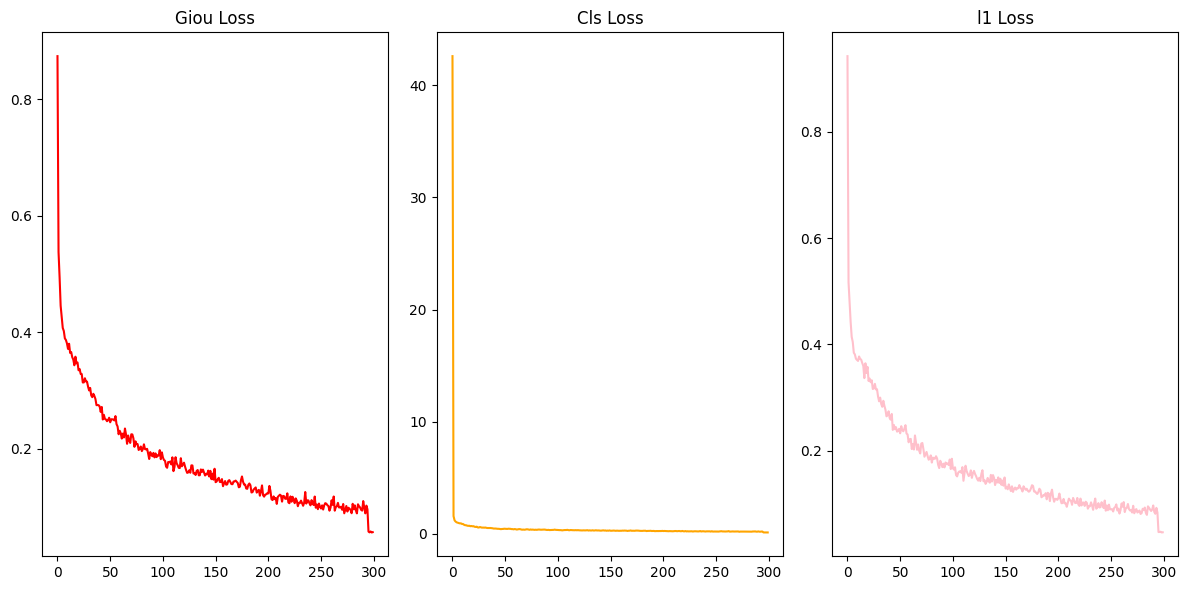

In [18]:
mdf = pd.read_csv('/kaggle/working/runs/detect/train/results.csv')
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.title('Giou Loss')
mdf1 = mdf[~mdf['train/giou_loss'].isna()]
mdf1['train/giou_loss'].plot(color='red')
plt.subplot(1,3,2)
plt.title('Cls Loss')
mdf2 = mdf[~mdf['train/cls_loss'].isna()]
mdf2['train/cls_loss'].plot(color='orange')
plt.subplot(1,3,3)
plt.title('l1 Loss')
mdf3 = mdf[~mdf['train/l1_loss'].isna()]
mdf3['train/l1_loss'].plot(color='pink')

plt.tight_layout()
plt.show()

#### GT vs Predict

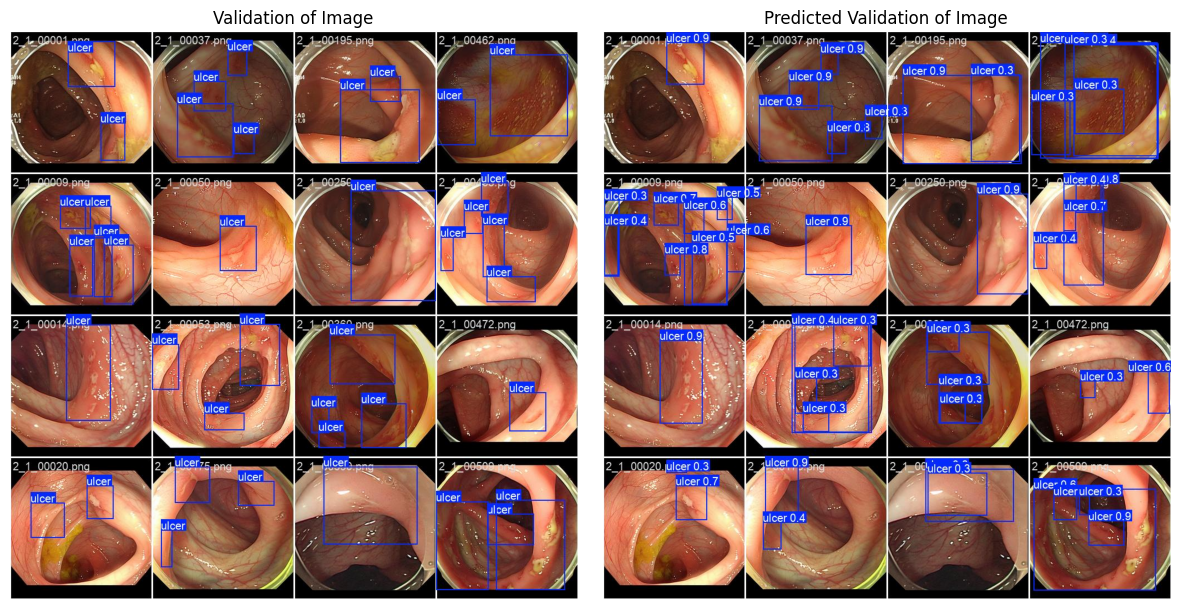

In [19]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
img = Image.open('/kaggle/working/runs/detect/train/val_batch0_labels.jpg')
img = np.array(img)
plt.title('Validation of Image')
plt.imshow(img)   
plt.axis('off')
    
plt.subplot(1,2,2)
img = Image.open('/kaggle/working/runs/detect/train/val_batch0_pred.jpg')
img = np.array(img)
plt.title('Predicted Validation of Image')
plt.imshow(img) 
plt.axis('off')

plt.tight_layout()
plt.show()

#### F1 Score & Precision & Recall

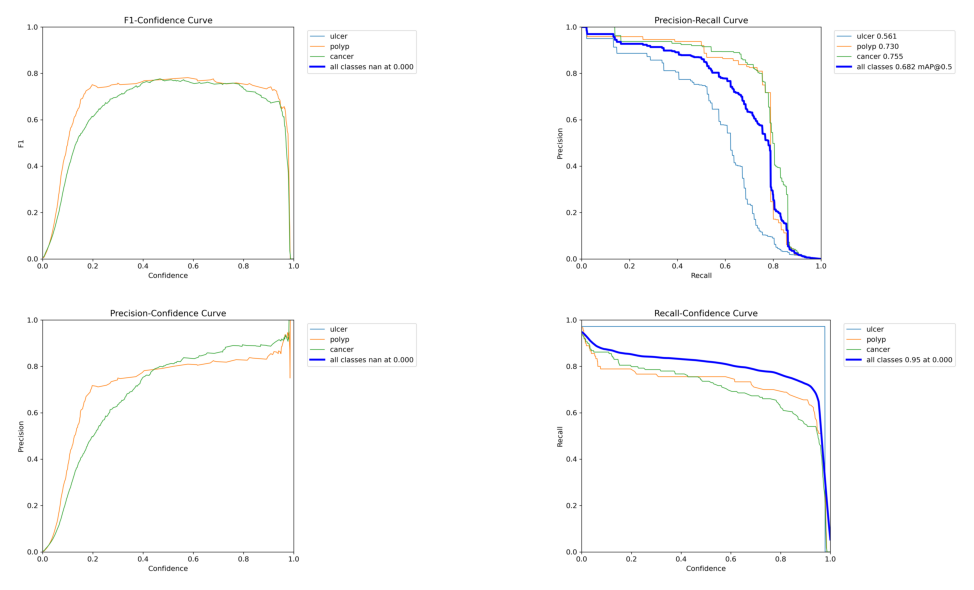

In [20]:
plt.figure(figsize=(12,6))

plt.subplot(2,2,1)
img = Image.open('/kaggle/working/runs/detect/train/F1_curve.png')
img = np.array(img)
plt.imshow(img)   
plt.axis('off')

plt.subplot(2,2,2)
img = Image.open('/kaggle/working/runs/detect/train/PR_curve.png')
img = np.array(img)
plt.imshow(img)   
plt.axis('off')

plt.subplot(2,2,3)
img = Image.open('/kaggle/working/runs/detect/train/P_curve.png')
img = np.array(img)
plt.imshow(img)   
plt.axis('off')

plt.subplot(2,2,4)
img = Image.open('/kaggle/working/runs/detect/train/R_curve.png')
img = np.array(img)
plt.imshow(img)   
plt.axis('off')



plt.tight_layout()
plt.show()

## 5. Evaluation

In [21]:
model = RTDETR('rtdetr-l.pt')
model = RTDETR(f'/kaggle/working/{CFG.output_dir}/train/weights/best.pt')

In [22]:
metrics = model.val(data='/kaggle/working/colonoscopy.yaml', imgsz=CFG.img_size[0], batch=CFG.batch*2, conf=CFG.conf, iou=CFG.iou, device=[0], 
                                project='runs/detect/val', name='metrics')

Ultralytics 8.3.84 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
rt-detr-l summary: 302 layers, 31,989,905 parameters, 0 gradients, 103.4 GFLOPs


val: Scanning /kaggle/working/runs/detect/val/labels.cache... 319 images, 0 backgrounds, 0 corrupt: 100%|██████████| 319/319 [00:00<?, ?it/s]

val: WARNING ⚠️ /kaggle/working/runs/detect/val/images/2_1_00009.png: 5 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/runs/detect/val/images/2_1_00053.png: 3 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


                   all        319        392      0.779      0.676      0.687      0.454
                 ulcer         78        143      0.714      0.531      0.565      0.238
                 polyp         82         90      0.806      0.767       0.74       0.59
                cancer        159        159      0.816       0.73      0.755      0.535
Speed: 0.4ms preprocess, 5.3ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val/metrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 9.2 MB/s eta 0:00:00


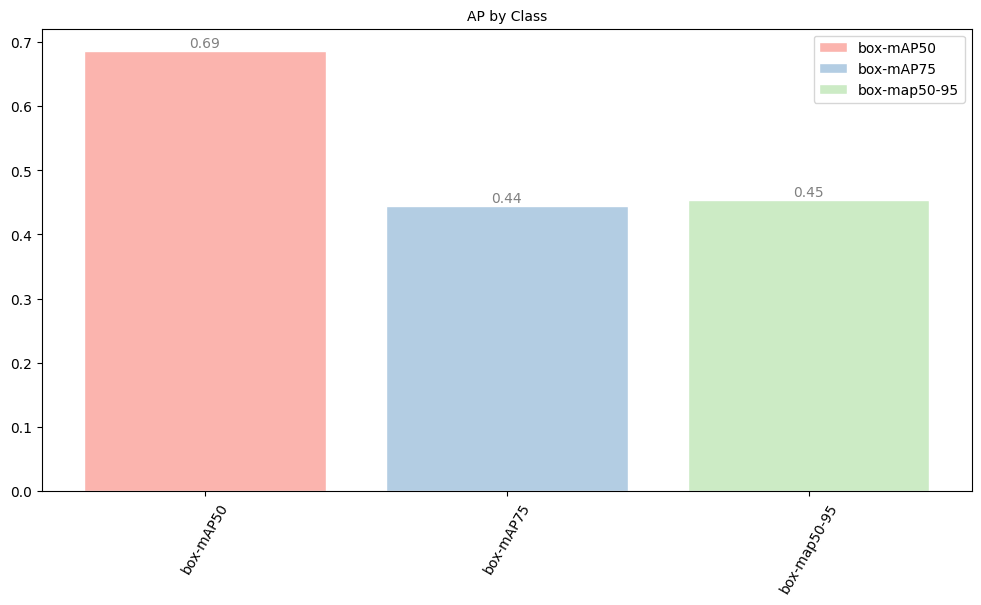

In [23]:
!pip -q install palettable
import palettable.colorbrewer.qualitative as pbq

plt.style.use('default')
plt.figure(figsize=(12,6))


plt.title('AP by Class', size=10)
ax = plt.bar(
    x=['box-mAP50','box-mAP75','box-map50-95'],
    height= [metrics.box.map50, metrics.box.map75, metrics.box.map],
    color=pbq.Pastel1_7.hex_colors,
    edgecolor='white',
    label=['box-mAP50','box-mAP75','box-map50-95']
)

# 막대 위에 텍스트 추가
for rect in ax.patches:
    x = rect.get_x() + rect.get_width() / 2.0  # 막대 중앙 x좌표
    y = rect.get_height()  # 막대 길이
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', size=10, color='gray')  # 텍스트 위치 조정


plt.legend()
plt.xticks(rotation=60)
plt.show()

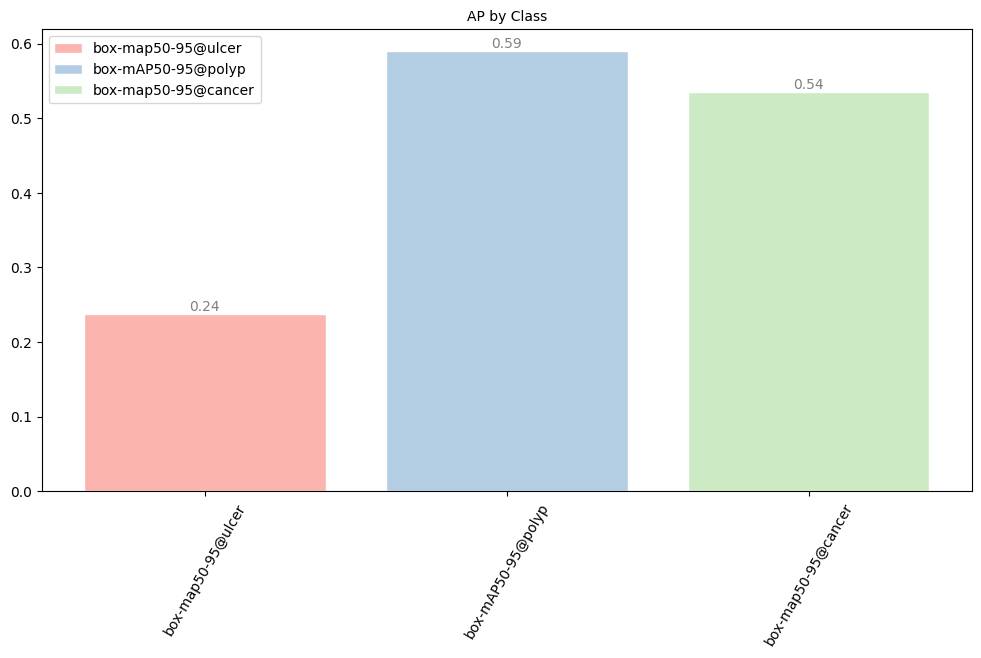

In [24]:
!pip -q install palettable
import palettable.colorbrewer.qualitative as pbq

plt.style.use('default')
plt.figure(figsize=(12,6))


plt.title('AP by Class', size=10)
ax = plt.bar(
    x=['box-map50-95@ulcer','box-mAP50-95@polyp','box-map50-95@cancer'],
    height= [metrics.box.maps[0], metrics.box.maps[1], metrics.box.maps[2]],
    color=pbq.Pastel1_7.hex_colors,
    edgecolor='white',
    label=['box-map50-95@ulcer','box-mAP50-95@polyp','box-map50-95@cancer']
)

# 막대 위에 텍스트 추가
for rect in ax.patches:
    x = rect.get_x() + rect.get_width() / 2.0  # 막대 중앙 x좌표
    y = rect.get_height()  # 막대 길이
    plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', size=10, color='gray')  # 텍스트 위치 조정


plt.legend()
plt.xticks(rotation=60)
plt.show()